In [1]:
import numpy as np
import torch
import torch.nn as nn

"""
Creating custom dataset for the task that is readable by the dataloader:
https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
"""
class CustomData(torch.utils.data.Dataset):
    def __init__(self, feature_len, sample_size, seed=0):
        np.random.seed(seed)  #Init random seed

        self.feature_len = feature_len
        self.sample_size = sample_size

    def __len__(self):
        return self.sample_size

    def __getitem__(self, idx):
        '''
        Generate the feature vector; random vector containing a vector of 
        vec_len elements with values of either -1.0, 0.0 or 1.0
        '''
        features = [np.random.choice([-1.0, 0.0, 1.0], 1)[0] 
                    for _ in range(self.feature_len)]
        target = sum([True if x == 1.0 else False for x in features]) % 2       #Calculate the parity of the vector; count the no. of instances of 1.0
        return torch.Tensor(features), target

In [2]:
"""
Create the Ponder Network that learns the optimal no. of iterations for the parity task
"""
class ParityPonderNetwork(nn.Module):
    def __init__(self, feature_len, nn_cell, ponder_steps, hidden_layers, 
                 seed=0):
        super().__init__()
        torch.manual_seed(seed)                                                 #Set seed in pytorch for reproducibility 
        self.ponder_steps = ponder_steps                                        #No. of steps to ponder for during training (no. of iterations to run)
        self.hidden_layers = hidden_layers                                      #No. of hidden layers
        self.out_l = nn.Linear(hidden_layers, 1)                                #Will output the y_hat (prediction)
        self.lamb_l = nn.Linear(hidden_layers, 1)                               #Will output the lambda (halting prob.)
        self.step_fn = nn_cell(feature_len, hidden_layers)                      #Instantiate the NN cell

    def forward(self, x, is_prediction=False):
        hidden_state = torch.zeros(x.shape[0], self.hidden_layers, 
                                   device=x.device)                             #Init the hidden state to zeros
        p_not_halted = torch.ones(x.shape[0], device=x.device)                  #Helper tensor that is updated dynamically, which stores the prob. that we have not yet halted
        batch_halt_idx = torch.zeros(x.shape[0], device=x.device)               #Init the halting steps for each batch to 0 to later store them
        predictions = torch.ones(self.ponder_steps,x.shape[0], 
                                 device=x.device)*10                            #Store the predictions at each step; init to all 10s to filter out unused rows easily
        probabilities = torch.zeros(self.ponder_steps,x.shape[0],
                                    device=x.device)*10                         #Store the probabilities at each step; ""
        step_lambda = torch.ones((x.shape[0],))                                 #Keep track of the lambdas at each iteration
        
        halting_step = self.ponder_steps                                        #To return of the halting step (if prediction)
        
        #Run the forward pass for the number of specified ponder steps
        for ponder_step in range(self.ponder_steps):
            
            predictions[ponder_step] = self.out_l(hidden_state)[:, 0]           #Get the new predictions and store them
                    
            '''Generate the lambdas; Run the hidden state through the 
            lambda layer and the sigmoid activation function 
            to return values between 0 and 1; generate next lambdas
            And if final pass, set lambdas to vector of 1s on the 
            final pass to make sure it stops
            '''
            step_lambda = torch.sigmoid(self.lamb_l(hidden_state))[:, 0] \
                if (ponder_step != self.ponder_steps-1) else  \
                    x.new_ones(x.shape[0])
            
            probabilities[ponder_step] = p_not_halted*step_lambda               #Calculate hte probability that we will stop at the current step and store it

            hidden_state = self.step_fn(x, hidden_state)                        #Generate new hidden state; always feeding the entire original feature vector into the cell
            
            p_not_halted = p_not_halted * (1-step_lambda)                       #Update the unhalted probs.; prob. of not halting at the step is 1-prob. of halting

            bernoulli_sample = torch.bernoulli(step_lambda)                     #Randomly generate binary tensor from a Bernoulli distribution using lambda as probabilies for each batch
            bernoulli_step = bernoulli_sample * (ponder_step + 1)               #Have every '1' value represent the current ponder step by mult. it with the step number

            '''Update the halting step to the current step for each batch if 
            the bernoulli sample generated a 1 for the current batch, which
            would have been a result of a high lambda for the batch (high prob)
            '''
            unhalted_batches = (batch_halt_idx == 0).nonzero(as_tuple=True)
            for i in unhalted_batches:
                batch_halt_idx[i] = bernoulli_step[i]

            halted_batch_count = torch.count_nonzero(batch_halt_idx).item()     #Check if all of the batches have halted
            if (is_prediction and halted_batch_count == x.shape[0]):            #Stop the loop if all batches have halted and model is trying to make a prediction (not train)
                predictions = predictions[predictions.sum(dim=1) != 
                    10*x.shape[0]]                                              #Return tensor of predictions up until stopping step
                probabilities = probabilities[probabilities.sum(dim=1) != 
                    10*x.shape[0]]                                              #Return tensor of predictions up until stopping step
                halting_step = ponder_step
                break

        return predictions, probabilities, batch_halt_idx, halting_step
        

In [3]:
class PonderLoss(nn.Module):
    def __init__(self, ponder_steps, loss_fn, geo_lambda, beta):
        super().__init__()

        self.loss_fn = loss_fn                                                  #Define the loss function (can just define here instead of making it an input param)
        geometric_probs = []                                                    #Init a tensor of zeros that we want to iteratively populate
        p_not_halted = 1.0                                                      #Represents the helper prob. that we have not halted yet

        '''For each sample, calculate the prob. of halting at the kth step is the 
        prob that we have not yet halted at any one of the previous steps and 
        that we will halt on the kth step
        '''
        for _ in range(ponder_steps):
            geometric_probs.append(p_not_halted * geo_lambda)
            p_not_halted = p_not_halted * (1-geo_lambda)                        #Update the probs. of not halting; this follows a geometric distribution as it continuously reduces

        geometric_probs = torch.tensor(geometric_probs)                         #Convert the list of geometric probs. to a tensor
        self.beta = beta

        '''Store the geometric dist. tensor in a buffer; tensor that we would like 
        to store fo the computation in the forward pass, but the tensor is not 
        trainable.
        '''
        self.register_buffer("geometric_probs", geometric_probs, True)

    def forward(self, halt_probs, targets, predictions):
        '''For each ponder step, compare the target values with the predictions 
        and weight them based on the geometric probability distribution.
        '''

        loss_val = torch.tensor(0.0, device=halt_probs.device, 
                                requires_grad=True)                             #Init the total loss
        
        '''
        For each step, compare the ground truth with the prediction and weight it based
        on the probability distribution; Reconstruction Loss
        '''
        for ponder_step in range(halt_probs.shape[0]):
            sample_loss = self.loss_fn(predictions[ponder_step], targets)       #Return the gross loss between the predictiona and targets
            weighted_loss = sample_loss * halt_probs[ponder_step]               #Calculat the weighted loss using the halting probabilities
            loss_val = torch.mean(weighted_loss) + loss_val                     #Aggregate the mean loss at the ponder step to the total reconstruction loss

        #Expand the pre-computed geometric distribution tensor across all samples; repeat the same tensor across all the batches
        batch_geometric_probs = torch.zeros((halt_probs.shape[1], halt_probs.shape[0]), device=halt_probs.device)
        for batch_no in range(batch_geometric_probs.shape[0]):
            batch_geometric_probs[batch_no] = self.geometric_probs[None,
                                                :halt_probs.shape[0]]           #Index from None in order to force array to become 2d        

        '''https://pytorch.org/docs/stable/generated/torch.nn.KLDivLoss.html
        Calculate the Kullback-Leibler divergence loss to force the 
        probabilities to follow a geometric distribution; Regularisation Loss
        '''
        kl_div_loss = torch.nn.KLDivLoss(reduction="batchmean")(torch.log(halt_probs.transpose(0, 1)), batch_geometric_probs)

        return loss_val + self.beta*kl_div_loss

In [7]:
def train(batch_size=128, feature_len=8, hidden_layers=64, geo_lambda=0.3, 
          ponder_steps=20, beta=0.01, learning_rate=3*10**(-4), epochs=100000, seed=0):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    dtype = torch.float32   #TODO: try to see if can remove this and following, if the model will still perform the same

    train_set = CustomData(feature_len, batch_size*epochs, seed)                #Generate training data
    train_data = torch.utils.data.DataLoader(train_set, 
                    batch_size=batch_size, num_workers=2)                       #Create dataloader for training data
    
    eval_set = CustomData(feature_len, 45*15, seed)                             #Generate evaluation data
    eval_data = torch.utils.data.DataLoader(eval_set, batch_size=45,
                                            num_workers=2)

    model = ParityPonderNetwork(feature_len, nn.GRUCell, ponder_steps, 
                hidden_layers, seed=seed).to(device, dtype)                     #Init the model wth GRU step-function; TODO: See if can use LSTM cell instead of GRU                  
    
    model_loss = PonderLoss(ponder_steps, 
                    nn.BCEWithLogitsLoss(reduction='none'), 
                        geo_lambda, beta).to(device, dtype)                     #Init the model loss with binary cross-entropy

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)          #Init the optimizer with Adam algorithm

    loss_tracker = []                                                           #Keep track of loss at every n iterations
    valid_accuracy = []                                                         #Keep track of overall accuracy when performing validation
    valid_avg_halting = []                                                      #Keep track of the average halting step when performing validation
    ponder_valid_acc = []                                                       #Keep track of per-ponder-step accuracy
    ponder_valid_avg_prob = []                                                  #Keep track of per-ponder-step average halting step

    '''
    Train the model
    '''
    model.train()                                                               #Put the model in training mode
    for i, t_data in enumerate(train_data):
        #Copy data to GPU
        features, labels = t_data
        features, labels = features.to(device, dtype), labels.to(device, dtype)
        
        predictions, probabilities, _, _ = model(features)                      #Run forward propogation for PonderNet

        loss = model_loss(probabilities, labels, predictions)                   #Compute the total loss of the predictions

        #Store outputs every 1000 iterations
        if (i % 1000 == 0):
            loss_tracker.append(loss.item())
            print(f"The loss at epoch {i} is: {loss}")

        '''Set the gradients to 0, compute the gradients and take the gradient 
        descent step.
        ''' 
        optimizer.zero_grad()                                                   #Clear gradients
        loss.backward()                                                         #Compute the gradients
        optimizer.step()                                                        #Update the parameters

        #Perform validation at every 5000 epochs
        if (i % 5000 == 0):
            model.eval()                                                        #Put the model in evaluation mode

            with torch.no_grad():                                               #Don't update the model's gradients
                epoch_valid_acc = []
                epoch_valid_avg_halt = []
                epoch_sample_valid_acc = []
                epoch_sample_valid_avg_prob = []

                for v_data in eval_data:
                    features, labels = v_data
                    features, labels = (features.to(device, dtype), 
                                        labels.to(device, dtype))

                    valid_preds, valid_probs, vaild_batch_halt_idx, _ = (
                        model(features))                                        #Get outputs from model

                    '''https://pytorch.org/docs/stable/generated/torch.gather.html
                    torch.gather uses the indeces passed to retrieve from the 
                    row and the column index of the index to retrieve from the 
                    column of the passed vector (in this case)
                    '''
                    vaild_batch_halt_preds = torch.gather(valid_preds, 0, 
                        vaild_batch_halt_idx[None, :].to(torch.int64)-1)[0]

                    #Calculate and store the mean accuracy of halted predicitons against the labels 
                    epoch_valid_acc.append(np.mean([1 
                        if ((vaild_batch_halt_preds[x] > 0) == labels[x]) 
                            else 0 for x in range(
                                vaild_batch_halt_preds.shape[0])]))

                    #Compute and store the average halting step over batches
                    epoch_valid_avg_halt.append(
                        np.mean(vaild_batch_halt_idx.tolist()))

                    #Compute the accuracy at each ponder step over batches
                    epoch_sample_valid_acc.append(np.mean([[True 
                        if ((valid_preds[x][z] > 0) == labels[z]) else False
                            for z in range(valid_preds.shape[1])] 
                                for x in range(valid_preds.shape[0])], 1))
                    
                    #Compute and store the mean probability for halting at each step
                    epoch_sample_valid_avg_prob.append(
                        np.mean(valid_probs.tolist(), 1))

                #Store mean stats from current evaluation iteration
                valid_accuracy.append(np.mean(epoch_valid_acc))
                valid_avg_halting.append(np.mean(epoch_valid_avg_halt))
                ponder_valid_acc.append(np.mean(epoch_sample_valid_acc, 0))
                ponder_valid_avg_prob.append(
                    np.mean(epoch_sample_valid_avg_prob, 0))
                print(f"\nThe mean accuracy at iteration {i} is: {valid_accuracy[-1]*100}")

            model.train()                                                       #Put the model back in trianing mode

    return loss_tracker, valid_accuracy, valid_avg_halting, ponder_valid_acc, ponder_valid_avg_prob, model, device

In [ ]:
loss_tracker, valid_accuracy, valid_avg_halting, ponder_valid_acc, ponder_valid_avg_prob, model, device = train(seed=32)

The loss at epoch 0 is: 0.6967188715934753

The mean accuracy at iteration 0 is: 52.0
The loss at epoch 1000 is: 0.6946810483932495
The loss at epoch 2000 is: 0.6926469206809998
The loss at epoch 3000 is: 0.694250762462616


#Plots

###Total Loss over Epochs

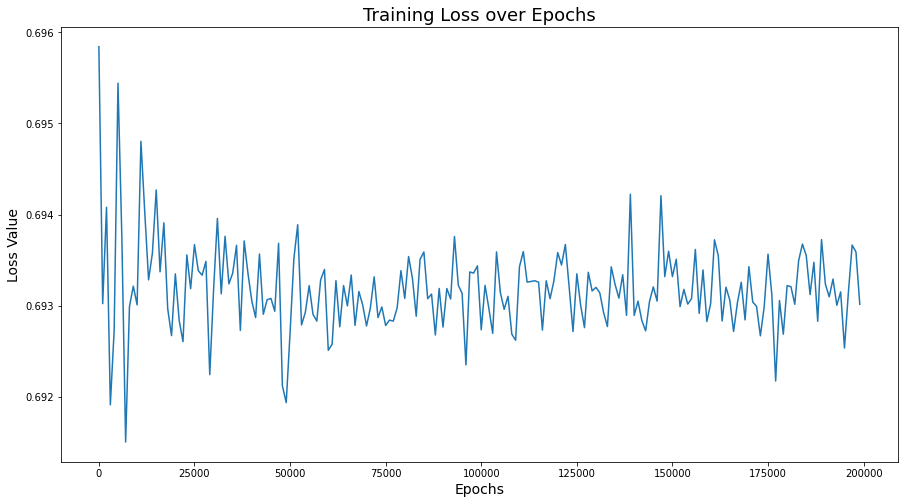

In [ ]:
import matplotlib.pyplot as plt

'''
Plot the Total Loss over epochs
'''
plt.figure(figsize=(15,8))
plt.plot([x*1000 for x in range(len(loss_tracker))], loss_tracker)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss Value', fontsize=14)
plt.title("Training Loss over Epochs", fontsize=18)
plt.savefig("8 Feat Training Loss")
plt.show()

###Validation Accuracy over epochs

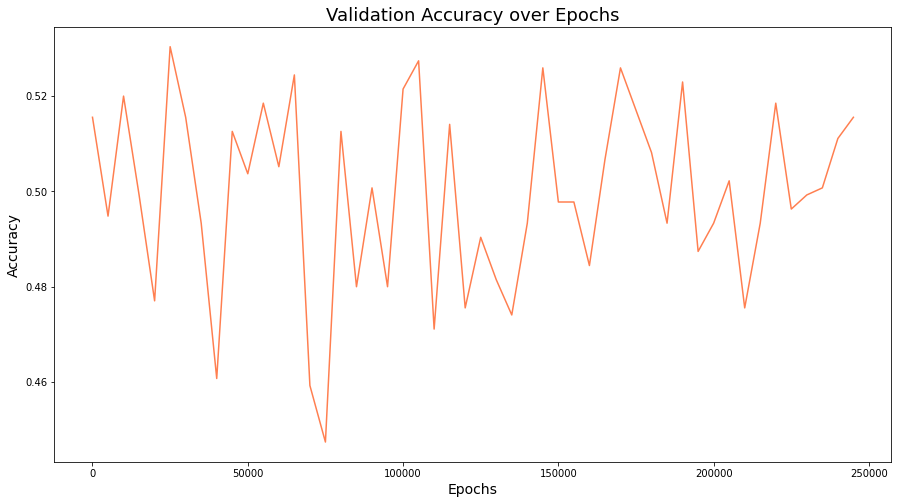

In [ ]:
'''
Plot the Accuracy of the Validation set over epochs
'''
plt.figure(figsize=(15,8))
plt.plot([x*5000 for x in range(len(valid_accuracy))], valid_accuracy, c='coral')
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.title("Validation Accuracy over Epochs", fontsize=18)
plt.savefig("8 Feat Validation Acc")
plt.show()

###Average Halting Step over Epochs during Validation

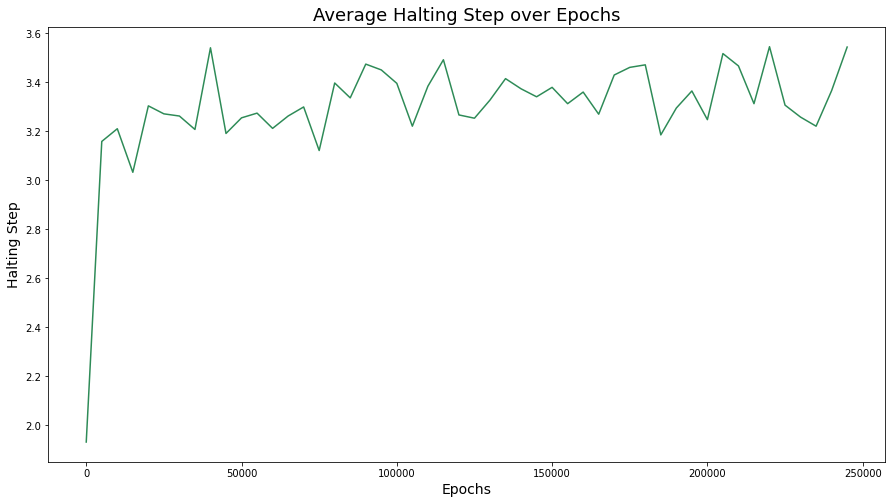

In [ ]:
'''
Plot the Average Halting Step of the Validation set over epochs
'''
# print(ponder_valid_acc)
plt.figure(figsize=(15,8))
plt.plot([x*5000 for x in range(len(valid_avg_halting))], valid_avg_halting, color='seagreen')
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Halting Step', fontsize=14)
plt.title("Average Halting Step over Epochs", fontsize=18)
plt.savefig("Feat Avg Halting")
plt.show()

###Prediction Accuracy of Model over Ponder Steps during Validation


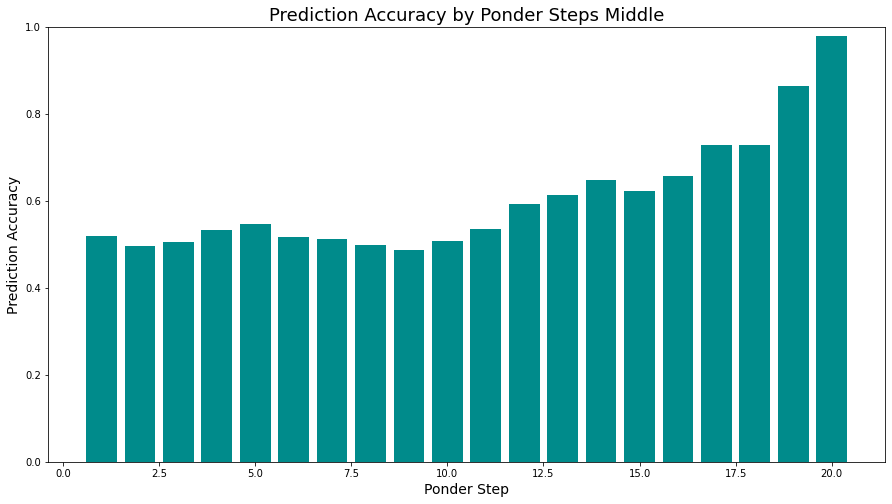

In [ ]:
'''
Plot the Accuracy over Ponder Steps
'''
plt.figure(figsize=(15,8))
plt.bar(range(1, len(ponder_valid_acc[-1])+1), ponder_valid_acc[-1], color='darkcyan')
plt.xlabel('Ponder Step', fontsize=14)
plt.ylabel('Prediction Accuracy', fontsize=14)
plt.title("Prediction Accuracy by Ponder Steps Middle", fontsize=18)
plt.ylim(0,1.0)
plt.savefig("Pred. Acc. Middle.png")
plt.show() 

###Predicted Values Probability Distribution during Validation

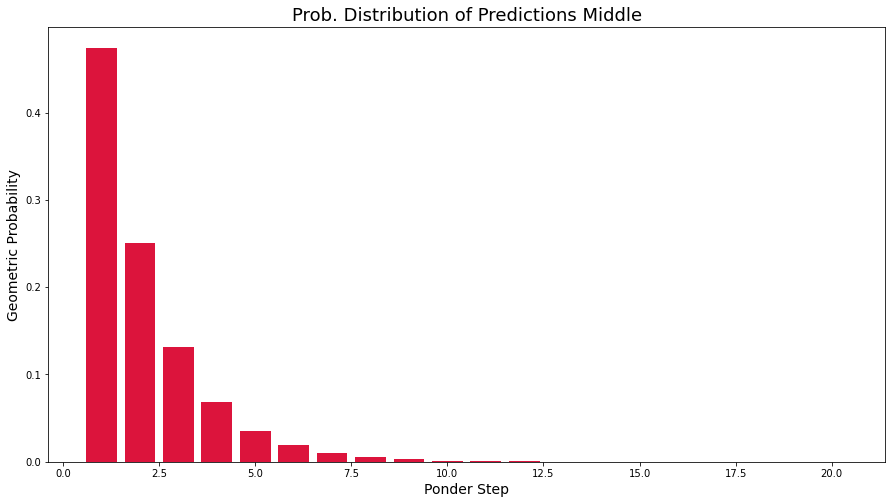

In [ ]:
'''
Plot the Probability Distribution of the Predictions
'''
plt.figure(figsize=(15,8))
plt.bar(list(range(1, len(ponder_valid_avg_prob[0])+1)), ponder_valid_avg_prob[0], color='crimson')
plt.xlabel('Ponder Step', fontsize=14)
plt.ylabel('Geometric Probability', fontsize=14)
plt.title("Prob. Distribution of Predictions Middle", fontsize=18)
plt.savefig("Prob. Dist Middle.png")
plt.show() 

#Testing

##Allow Halting

In [ ]:
#Create test dataloader
test_set = CustomData(15, 64*50000, 0)                             #Generate evaluation data
test_data = torch.utils.data.DataLoader(test_set, batch_size=64,num_workers=2)

model.eval()                                                        #Put the model in evaluation mode
with torch.no_grad():                                               #Don't update the model's gradients
    epoch_test_acc = []

    for t_data in test_data:

        features, labels = t_data
        features, labels = (features.to(device), 
                            labels.to(device))

        test_preds, test_probs, test_batch_halt_idx, _ = (
            model(features, True))                                  #Get outputs from model

        '''https://pytorch.org/docs/stable/generated/torch.gather.html
        torch.gather uses the indeces passed to retrieve from the 
        row and the column index of the index to retrieve from the 
        column of the passed vector (in this case)
        '''
        test_batch_halt_preds = torch.gather(test_preds, 0, 
            test_batch_halt_idx[None, :].to(torch.int64)-1)[0]

        #Calculate and store the mean accuracy of halted predicitons against the labels 
        epoch_test_acc.append(np.mean([1 
            if ((test_batch_halt_preds[x] > 0) == labels[x]) 
                else 0 for x in range(
                    test_batch_halt_preds.shape[0])]))


    print(f"\nThe final mean running all steps is: {np.mean(epoch_test_acc)}")

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f10b2e91320>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f10b2e91320>
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
    if w.is_alive():
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    if w.is_alive():
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
  File "/usr/lib/pytho

KeyboardInterrupt: ignored

##Run all Steps

In [ ]:
model.eval()                                                        #Put the model in evaluation mode
with torch.no_grad():                                               #Don't update the model's gradients
    epoch_test_acc = []

    for t_data in test_data:
        features, labels = t_data
        features, labels = (features.to(device, dtype), 
                            labels.to(device, dtype))

        test_preds, test_probs, test_batch_halt_idx, _ = (
            model(features))                                  #Get outputs from model

        '''https://pytorch.org/docs/stable/generated/torch.gather.html
        torch.gather uses the indeces passed to retrieve from the 
        row and the column index of the index to retrieve from the 
        column of the passed vector (in this case)
        '''
        test_batch_halt_preds = torch.gather(test_preds, 0, 
            test_batch_halt_idx[None, :].to(torch.int64)-1)[0]

        #Calculate and store the mean accuracy of halted predicitons against the labels 
        epoch_test_acc.append(np.mean([1 
            if ((test_batch_halt_preds[x] > 0) == labels[x]) 
                else 0 for x in range(
                    test_batch_halt_preds.shape[0])]))


    print(f"\nThe final mean running all steps is: {np.mean(epoch_test_acc)}")